In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import logging
import os
import time
from multiprocessing import Process
from pgportfolio.learn.tradertrainer import TraderTrainer
from pgportfolio.tools.configprocess import load_config


def train_one(save_path, config, log_file_dir, index, logfile_level, console_level, device):
    """
    train an agent
    :param save_path: the path to save the tensorflow model (.ckpt), could be None
    :param config: the json configuration file
    :param log_file_dir: the directory to save the tensorboard logging file, could be None
    :param index: identifier of this train, which is also the sub directory in the train_package,
    if it is 0. nothing would be saved into the summary file.
    :param logfile_level: logging level of the file
    :param console_level: logging level of the console
    :param device: 0 or 1 to show which gpu to use, if 0, means use cpu instead of gpu
    :return : the Result namedtuple
    """
    if log_file_dir:
        logging.basicConfig(filename=log_file_dir.replace("tensorboard","programlog"),
                            level=logfile_level)
        console = logging.StreamHandler()
        console.setLevel(console_level)
        logging.getLogger().addHandler(console)
    print("training at %s started" % index)
    return TraderTrainer(config, save_path=save_path, device=device).train_net(log_file_dir=log_file_dir, index=index)

def train_all(processes=1, device="cpu"):
    """
    train all the agents in the train_package folders

    :param processes: the number of the processes. If equal to 1, the logging level is debug
                      at file and info at console. If greater than 1, the logging level is
                      info at file and warming at console.
    """
    if processes == 1:
        console_level = logging.INFO
        logfile_level = logging.DEBUG
    else:
        console_level = logging.WARNING
        logfile_level = logging.INFO
    train_dir = "train_package"
    if not os.path.exists("./" + train_dir): #if the directory does not exist, creates one
        os.makedirs("./" + train_dir)
    all_subdir = os.listdir("./" + train_dir)
    all_subdir.sort()
    pool = []
    for dir in all_subdir:
        # train only if the log dir does not exist
        if not str.isdigit(dir):
            return
        # NOTE: logfile is for compatibility reason
        if not (os.path.isdir("./"+train_dir+"/"+dir+"/tensorboard") or os.path.isdir("./"+train_dir+"/"+dir+"/logfile")):
            p = Process(target=train_one, args=(
                "./" + train_dir + "/" + dir + "/netfile",
                load_config(dir),
                "./" + train_dir + "/" + dir + "/tensorboard",
                dir, logfile_level, console_level, device))
            p.start()
            pool.append(p)
        else:
            continue

        # suspend if the processes are too many
        wait = True
        while wait:
            time.sleep(5)
            for p in pool:
                alive = p.is_alive()
                if not alive:
                    pool.remove(p)
            if len(pool)<processes:
                wait = False
    print("All the Tasks are Over")



/Users/adilrhiulam/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
import matplotlib.pyplot as plt

In [3]:
fig, ax = plt.subplots()

In [4]:
train_dir = "train_package"

In [5]:
all_subdir = os.listdir("./" + train_dir)

['.DS_Store', '1']

In [6]:
dir='1'
console_level = logging.INFO
logfile_level = logging.DEBUG
device="cpu"

In [93]:
p = Process(target=train_one, args=("./" + train_dir + "/" + dir + "/netfile",load_config(dir),"./" + train_dir + "/" + dir + "/tensorboard",dir, logfile_level, console_level, device))


In [94]:
p.start()

training at 1 started
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
From /Users/adilrhiulam/Downloads/PGPortfolio-master/tflearn/initializations.py:119: UniformUnitScaling.__init__ (from tensorflow.python.ops.init_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


In [35]:
pool = []
pool.append(p)

In [36]:
pool

[<Process(Process-1, stopped)>]

In [7]:
import numpy as np
A= np.array([[1,2,4],[2,5,10],[4,10,21]])

In [8]:
from __future__ import absolute_import, print_function, division
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rc
import pandas as pd
import logging
import json
import numpy as np
import datetime
from pgportfolio.tools.indicator import max_drawdown, sharpe, positive_count, negative_count, moving_accumulate
from pgportfolio.tools.configprocess import parse_time, check_input_same
from pgportfolio.tools.shortcut import execute_backtest

# the dictionary of name of indicators mapping to the function of related indicators
# input is portfolio changes
INDICATORS = {"portfolio value": np.prod,
              "sharpe ratio": sharpe,
              "max drawdown": max_drawdown,
              "positive periods": positive_count,
              "negative periods": negative_count,
              "postive day": lambda pcs: positive_count(moving_accumulate(pcs, 48)),
              "negative day": lambda pcs: negative_count(moving_accumulate(pcs, 48)),
              "postive week": lambda pcs: positive_count(moving_accumulate(pcs, 336)),
              "negative week": lambda pcs: negative_count(moving_accumulate(pcs, 336)),
              "average": np.mean}

NAMES = {"best": "Best Stock (Benchmark)",
         "crp": "UCRP (Benchmark)",
         "ubah": "UBAH (Benchmark)",
         "anticor": "ANTICOR",
         "olmar": "OLMAR",
         "pamr": "PAMR",
         "cwmr": "CWMR",
         "rmr": "RMR",
         "ons": "ONS",
         "up": "UP",
         "eg": "EG",
         "bk": "BK",
         "corn": "CORN",
         "m0": "M0",
         "wmamr": "WMAMR"
         }

def plot_backtest(config, algos, labels=None):
    """
    @:param config: config dictionary
    @:param algos: list of strings representing the name of algorithms or index of pgportfolio result
    """
    results = []
    for i, algo in enumerate(algos):
        if algo.isdigit():
            results.append(np.cumprod(_load_from_summary(algo, config)))
            logging.info("load index "+algo+" from csv file")
        else:
            logging.info("start executing "+algo)
            results.append(np.cumprod(execute_backtest(algo, config)))
            logging.info("finish executing "+algo)

    start, end = _extract_test(config)
    timestamps = np.linspace(start, end, len(results[0]))
    dates = [datetime.datetime.fromtimestamp(int(ts)-int(ts)%config["input"]["global_period"])
             for ts in timestamps]

    weeks = mdates.WeekdayLocator()
    days = mdates.DayLocator()

    rc("font", **{"family": "sans-serif", "sans-serif": ["Helvetica"],
                  "size": 8})

    """
    styles = [("-", None), ("--", None), ("", "+"), (":", None),
              ("", "o"), ("", "v"), ("", "*")]
    """
    fig, ax = plt.subplots()
    fig.set_size_inches(9, 5)
    for i, pvs in enumerate(results):
        if len(labels) > i:
            label = labels[i]
        else:
            label = NAMES[algos[i]]
        ax.semilogy(dates, pvs, linewidth=1, label=label)
        #ax.plot(dates, pvs, linewidth=1, label=label)

    plt.ylabel("portfolio value $p_t/p_0$", fontsize=12)
    plt.xlabel("time", fontsize=12)
    xfmt = mdates.DateFormatter("%m-%d %H:%M")
    ax.xaxis.set_major_locator(weeks)
    ax.xaxis.set_minor_locator(days)
    datemin = dates[0]
    datemax = dates[-1]
    ax.set_xlim(datemin, datemax)

    ax.xaxis.set_major_formatter(xfmt)
    plt.grid(True)
    plt.tight_layout()
    ax.legend(loc="upper left", prop={"size":10})
    fig.autofmt_xdate()
    plt.savefig("result.eps", bbox_inches='tight',
                pad_inches=0)
    plt.show()


def table_backtest(config, algos, labels=None, format="raw",
                   indicators=list(INDICATORS.keys())):
    """
    @:param config: config dictionary
    @:param algos: list of strings representing the name of algorithms
    or index of pgportfolio result
    @:param format: "raw", "html", "latex" or "csv". If it is "csv",
    the result will be save in a csv file. otherwise only print it out
    @:return: a string of html or latex code
    """
    results = []
    labels = list(labels)
    for i, algo in enumerate(algos):
        if algo.isdigit():
            portfolio_changes = _load_from_summary(algo, config)
            logging.info("load index " + algo + " from csv file")
        else:
            logging.info("start executing " + algo)
            portfolio_changes = execute_backtest(algo, config)
            logging.info("finish executing " + algo)

        indicator_result = {}
        for indicator in indicators:
            indicator_result[indicator] = INDICATORS[indicator](portfolio_changes)
        results.append(indicator_result)
        if len(labels)<=i:
            labels.append(NAMES[algo])

    dataframe = pd.DataFrame(results, index=labels)

    start, end = _extract_test(config)
    start = datetime.datetime.fromtimestamp(start - start%config["input"]["global_period"])
    end = datetime.datetime.fromtimestamp(end - end%config["input"]["global_period"])

    print("backtest start from "+ str(start) + " to " + str(end))
    if format == "html":
        print(dataframe.to_html())
    elif format == "latex":
        print(dataframe.to_latex())
    elif format == "raw":
        print(dataframe.to_string())
    elif format == "csv":
        dataframe.to_csv("./compare"+end.strftime("%Y-%m-%d")+".csv")
    else:
        raise ValueError("The format " + format + " is not supported")


def _extract_test(config):
    global_start = parse_time(config["input"]["start_date"])
    global_end = parse_time(config["input"]["end_date"])
    span = global_end - global_start
    start = global_end - config["input"]["test_portion"] * span
    end = global_end
    return start, end


def _load_from_summary(index, config):
    """ load the backtest result form train_package/train_summary
    @:param index: index of the training and backtest
    @:return: numpy array of the portfolio changes
    """
    dataframe = pd.DataFrame.from_csv("./train_package/train_summary.csv")
    history_string = dataframe.loc[int(index)]["backtest_test_history"]
    if not check_input_same(config, json.loads(dataframe.loc[int(index)]["config"])):
        raise ValueError("the date of this index is not the same as the default config")
    return np.fromstring(history_string, sep=",")[:-1]




In [56]:
python main.py --mode=table --algos=1,olmar,ons --labels=nntrader,olmar,ons

SyntaxError: invalid syntax (<ipython-input-56-deab1b83f76f>, line 1)

In [9]:
from __future__ import absolute_import
import json
import logging
import os
import time
from argparse import ArgumentParser
from datetime import datetime

from pgportfolio.tools.configprocess import preprocess_config
from pgportfolio.tools.configprocess import load_config
from pgportfolio.tools.trade import save_test_data
from pgportfolio.tools.shortcut import execute_backtest
from pgportfolio.resultprocess import plot


def build_parser():
    parser = ArgumentParser()
    parser.add_argument("--mode",dest="mode",
                        help="start mode, train, generate, download_data"
                             " backtest",
                        metavar="MODE", default="train")
    parser.add_argument("--processes", dest="processes",
                        help="number of processes you want to start to train the network",
                        default="1")
    parser.add_argument("--repeat", dest="repeat",
                        help="repeat times of generating training subfolder",
                        default="1")
    parser.add_argument("--algo",
                        help="algo name or indexes of training_package ",
                        dest="algo")
    parser.add_argument("--algos",
                        help="algo names or indexes of training_package, seperated by \",\"",
                        dest="algos")
    parser.add_argument("--labels", dest="labels",
                        help="names that will shown in the figure caption or table header")
    parser.add_argument("--format", dest="format", default="raw",
                        help="format of the table printed")
    parser.add_argument("--device", dest="device", default="cpu",
                        help="device to be used to train")
    parser.add_argument("--folder", dest="folder", type=int,
                        help="folder(int) to load the config, neglect this option if loading from ./pgportfolio/net_config")
    return parser


def main():
    parser = build_parser()
    options = parser.parse_args()
    if not os.path.exists("./" + "train_package"):
        os.makedirs("./" + "train_package")
    if not os.path.exists("./" + "database"):
        os.makedirs("./" + "database")

    if options.mode == "train":
        import pgportfolio.autotrain.training
        if not options.algo:
            pgportfolio.autotrain.training.train_all(int(options.processes), options.device)
        else:
            for folder in options.train_floder:
                raise NotImplementedError()
    elif options.mode == "generate":
        import pgportfolio.autotrain.generate as generate
        logging.basicConfig(level=logging.INFO)
        generate.add_packages(load_config(), int(options.repeat))
    elif options.mode == "download_data":
        from pgportfolio.marketdata.datamatrices import DataMatrices
        with open("./pgportfolio/net_config.json") as file:
            config = json.load(file)
        config = preprocess_config(config)
        start = time.mktime(datetime.strptime(config["input"]["start_date"], "%Y/%m/%d").timetuple())
        end = time.mktime(datetime.strptime(config["input"]["end_date"], "%Y/%m/%d").timetuple())
        DataMatrices(start=start,
                     end=end,
                     feature_number=config["input"]["feature_number"],
                     window_size=config["input"]["window_size"],
                     online=True,
                     period=config["input"]["global_period"],
                     volume_average_days=config["input"]["volume_average_days"],
                     coin_filter=config["input"]["coin_number"],
                     is_permed=config["input"]["is_permed"],
                     test_portion=config["input"]["test_portion"],
                     portion_reversed=config["input"]["portion_reversed"])
    elif options.mode == "backtest":
        config = _config_by_algo(options.algo)
        _set_logging_by_algo(logging.DEBUG, logging.DEBUG, options.algo, "backtestlog")
        execute_backtest(options.algo, config)
    elif options.mode == "save_test_data":
        # This is used to export the test data
        save_test_data(load_config(options.folder))
    elif options.mode == "plot":
        logging.basicConfig(level=logging.INFO)
        algos = options.algos.split(",")
        if options.labels:
            labels = options.labels.replace("_"," ")
            labels = labels.split(",")
        else:
            labels = algos
        plot.plot_backtest(load_config(), algos, labels)
    elif options.mode == "table":
        algos = options.algos.split(",")
        if options.labels:
            labels = options.labels.replace("_"," ")
            labels = labels.split(",")
        else:
            labels = algos
        plot.table_backtest(load_config(), algos, labels, format=options.format)

def _set_logging_by_algo(console_level, file_level, algo, name):
    if algo.isdigit():
            logging.basicConfig(filename="./train_package/"+algo+"/"+name,
                                level=file_level)
            console = logging.StreamHandler()
            console.setLevel(console_level)
            logging.getLogger().addHandler(console)
    else:
        logging.basicConfig(level=console_level)


def _config_by_algo(algo):
    """
    :param algo: a string represent index or algo name
    :return : a config dictionary
    """
    if not algo:
        raise ValueError("please input a specific algo")
    elif algo.isdigit():
        config = load_config(algo)
    else:
        config = load_config()
    return config




In [ ]:
logging.basicConfig(level=logging.INFO)
algos = options.algos.split(",")
if options.labels:
    labels = options.labels.replace("_"," ")
    labels = labels.split(",")
else:
    labels = algos
plot.plot_backtest(load_config(), algos, labels)

In [10]:
from __future__ import absolute_import, print_function, division
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rc
import pandas as pd
import logging
import json
import numpy as np
import datetime


# the dictionary of name of indicators mapping to the function of related indicators
# input is portfolio changes
INDICATORS = {"portfolio value": np.prod,
              "sharpe ratio": sharpe,
              "max drawdown": max_drawdown,
              "positive periods": positive_count,
              "negative periods": negative_count,
              "postive day": lambda pcs: positive_count(moving_accumulate(pcs, 48)),
              "negative day": lambda pcs: negative_count(moving_accumulate(pcs, 48)),
              "postive week": lambda pcs: positive_count(moving_accumulate(pcs, 336)),
              "negative week": lambda pcs: negative_count(moving_accumulate(pcs, 336)),
              "average": np.mean}

NAMES = {"best": "Best Stock (Benchmark)",
         "crp": "UCRP (Benchmark)",
         "ubah": "UBAH (Benchmark)",
         "anticor": "ANTICOR",
         "olmar": "OLMAR",
         "pamr": "PAMR",
         "cwmr": "CWMR",
         "rmr": "RMR",
         "ons": "ONS",
         "up": "UP",
         "eg": "EG",
         "bk": "BK",
         "corn": "CORN",
         "m0": "M0",
         "wmamr": "WMAMR"
         }

def plot_backtest(config, algos, labels=None):
    """
    @:param config: config dictionary
    @:param algos: list of strings representing the name of algorithms or index of pgportfolio result
    """
    results = []
    for i, algo in enumerate(algos):
        if algo.isdigit():
            results.append(np.cumprod(_load_from_summary(algo, config)))
            logging.info("load index "+algo+" from csv file")
        else:
            logging.info("start executing "+algo)
            results.append(np.cumprod(execute_backtest(algo, config)))
            logging.info("finish executing "+algo)

    start, end = _extract_test(config)
    timestamps = np.linspace(start, end, len(results[0]))
    dates = [datetime.datetime.fromtimestamp(int(ts)-int(ts)%config["input"]["global_period"])
             for ts in timestamps]

    weeks = mdates.WeekdayLocator()
    days = mdates.DayLocator()

    rc("font", **{"family": "sans-serif", "sans-serif": ["Helvetica"],
                  "size": 8})

    """
    styles = [("-", None), ("--", None), ("", "+"), (":", None),
              ("", "o"), ("", "v"), ("", "*")]
    """
    fig, ax = plt.subplots()
    fig.set_size_inches(9, 5)
    for i, pvs in enumerate(results):
        if len(labels) > i:
            label = labels[i]
        else:
            label = NAMES[algos[i]]
        ax.semilogy(dates, pvs, linewidth=1, label=label)
        #ax.plot(dates, pvs, linewidth=1, label=label)

    plt.ylabel("portfolio value $p_t/p_0$", fontsize=12)
    plt.xlabel("time", fontsize=12)
    xfmt = mdates.DateFormatter("%m-%d %H:%M")
    ax.xaxis.set_major_locator(weeks)
    ax.xaxis.set_minor_locator(days)
    datemin = dates[0]
    datemax = dates[-1]
    ax.set_xlim(datemin, datemax)
    ax.set_title('number of assets = 3')
    ax.xaxis.set_major_formatter(xfmt)
    plt.grid(False)
    plt.tight_layout()
    ax.legend(loc="upper left", prop={"size":10})
    fig.autofmt_xdate()
    plt.savefig("result.eps", bbox_inches='tight',
                pad_inches=0)
    
    plt.show()


def table_backtest(config, algos, labels=None, format="raw",
                   indicators=list(INDICATORS.keys())):
    """
    @:param config: config dictionary
    @:param algos: list of strings representing the name of algorithms
    or index of pgportfolio result
    @:param format: "raw", "html", "latex" or "csv". If it is "csv",
    the result will be save in a csv file. otherwise only print it out
    @:return: a string of html or latex code
    """
    results = []
    labels = list(labels)
    for i, algo in enumerate(algos):
        if algo.isdigit():
            portfolio_changes = _load_from_summary(algo, config)
            logging.info("load index " + algo + " from csv file")
        else:
            logging.info("start executing " + algo)
            portfolio_changes = execute_backtest(algo, config)
            logging.info("finish executing " + algo)

        indicator_result = {}
        for indicator in indicators:
            indicator_result[indicator] = INDICATORS[indicator](portfolio_changes)
        results.append(indicator_result)
        if len(labels)<=i:
            labels.append(NAMES[algo])

    dataframe = pd.DataFrame(results, index=labels)

    start, end = _extract_test(config)
    start = datetime.datetime.fromtimestamp(start - start%config["input"]["global_period"])
    end = datetime.datetime.fromtimestamp(end - end%config["input"]["global_period"])

    print("backtest start from "+ str(start) + " to " + str(end))
    if format == "html":
        print(dataframe.to_html())
    elif format == "latex":
        print(dataframe.to_latex())
    elif format == "raw":
        print(dataframe.to_string())
    elif format == "csv":
        dataframe.to_csv("./compare"+end.strftime("%Y-%m-%d")+".csv")
    else:
        raise ValueError("The format " + format + " is not supported")


def _extract_test(config):
    global_start = parse_time(config["input"]["start_date"])
    global_end = parse_time(config["input"]["end_date"])
    span = global_end - global_start
    start = global_end - config["input"]["test_portion"] * span
    end = global_end
    return start, end


def _load_from_summary(index, config):
    """ load the backtest result form train_package/train_summary
    @:param index: index of the training and backtest
    @:return: numpy array of the portfolio changes
    """
    dataframe = pd.DataFrame.from_csv("./train_package/train_summary.csv")
    history_string = dataframe.loc[int(index)]["backtest_test_history"]
    if not check_input_same(config, json.loads(dataframe.loc[int(index)]["config"])):
        raise ValueError("the date of this index is not the same as the default config")
    return np.fromstring(history_string, sep=",")[:-1]




In [42]:
#dataframe = pd.DataFrame.from_csv("/Users/adilrhiulam/Downloads/PGPortfolio-master/3ass/train_summary.csv")
#dataframe2 = pd.DataFrame.from_csv("/Users/adilrhiulam/Downloads/PGPortfolio-master/train_package/train_summary.csv")
dataframe3 = pd.DataFrame.from_csv("/Users/adilrhiulam/Downloads/PGPortfolio-master/train_package/train_summary.csv")

In [2]:
import pandas as pd

In [5]:
table= pd.read_csv("/Users/adilrhiulam/Downloads/PGPortfolio-master/11assets/train_summary.csv",sep=",")

In [6]:
table

,net_dir,test_pv,test_log_mean,test_log_mean_free,test_history,config,backtest_test_pv,backtest_test_history,backtest_test_log_mean,training_time
0,1,9.537433,0.000812,0.003215,"1.00479, 1.00244, 1.00554, 0.999282, 1.00744, ...","{""agent_type"": ""NNAgent"", ""input"": {""coin_numb...",53.024788,"1.00228, 1.00165, 1.00526, 1.00194, 1.00832, 0...",0.00143,802


In [43]:
#history_string = dataframe.loc[int(1)]["backtest_test_history"]
#history_string2 = dataframe2.loc[int(1)]["backtest_test_history"]
history_string3 = dataframe3.loc[int(1)]["backtest_test_history"]

In [44]:
#x=np.fromstring(history_string, sep=",")[:-1]
#y = np.fromstring(history_string2, sep=",")[:-1]
z = np.fromstring(history_string3, sep=",")[:-1]

In [ ]:
plt.figure(1,figsize=(10,5))
plt.plot(np.cumsum(np.log(z)),label='CNN agent')
plt.plot(np.cumsum(np.log(test1)),label='OLMAR')
plt.plot(np.cumsum(np.log(test4)),label='UP')
plt.plot(np.cumsum(np.log(test2)),label='PAMR')
plt.plot(np.cumsum(np.log(test5)),label='EG', alpha = 1)
plt.ylabel('Cumulative Reward')
plt.xlabel('Periods')
plt.legend()
plt.show()

In [14]:
from multiprocessing import Process

In [29]:
def f(name):
    print ('hello', name)
p = Process(target=f, args=('bob',))



In [30]:
p.start()

hello bob


In [14]:
from pgportfolio.tools.shortcut import execute_backtest

In [15]:
from __future__ import absolute_import
import json
import logging
import os
import time
from argparse import ArgumentParser
from datetime import datetime

from pgportfolio.tools.configprocess import preprocess_config
from pgportfolio.tools.configprocess import load_config
from pgportfolio.tools.trade import save_test_data
from pgportfolio.tools.shortcut import execute_backtest
from pgportfolio.resultprocess import plot


def build_parser():
    parser = ArgumentParser()
    parser.add_argument("--mode",dest="mode",
                        help="start mode, train, generate, download_data"
                             " backtest",
                        metavar="MODE", default="train")
    parser.add_argument("--processes", dest="processes",
                        help="number of processes you want to start to train the network",
                        default="1")
    parser.add_argument("--repeat", dest="repeat",
                        help="repeat times of generating training subfolder",
                        default="1")
    parser.add_argument("--algo",
                        help="algo name or indexes of training_package ",
                        dest="algo")
    parser.add_argument("--algos",
                        help="algo names or indexes of training_package, seperated by \",\"",
                        dest="algos")
    parser.add_argument("--labels", dest="labels",
                        help="names that will shown in the figure caption or table header")
    parser.add_argument("--format", dest="format", default="raw",
                        help="format of the table printed")
    parser.add_argument("--device", dest="device", default="cpu",
                        help="device to be used to train")
    parser.add_argument("--folder", dest="folder", type=int,
                        help="folder(int) to load the config, neglect this option if loading from ./pgportfolio/net_config")
    return parser


def main():
    parser = build_parser()
    options = parser.parse_args()
    if not os.path.exists("./" + "train_package"):
        os.makedirs("./" + "train_package")
    if not os.path.exists("./" + "database"):
        os.makedirs("./" + "database")

    if options.mode == "train":
        import pgportfolio.autotrain.training
        if not options.algo:
            pgportfolio.autotrain.training.train_all(int(options.processes), options.device)
        else:
            for folder in options.train_floder:
                raise NotImplementedError()
    elif options.mode == "generate":
        import pgportfolio.autotrain.generate as generate
        logging.basicConfig(level=logging.INFO)
        generate.add_packages(load_config(), int(options.repeat))
    elif options.mode == "download_data":
        from pgportfolio.marketdata.datamatrices import DataMatrices
        with open("./pgportfolio/net_config.json") as file:
            config = json.load(file)
        config = preprocess_config(config)
        start = time.mktime(datetime.strptime(config["input"]["start_date"], "%Y/%m/%d").timetuple())
        end = time.mktime(datetime.strptime(config["input"]["end_date"], "%Y/%m/%d").timetuple())
        DataMatrices(start=start,
                     end=end,
                     feature_number=config["input"]["feature_number"],
                     window_size=config["input"]["window_size"],
                     online=True,
                     period=config["input"]["global_period"],
                     volume_average_days=config["input"]["volume_average_days"],
                     coin_filter=config["input"]["coin_number"],
                     is_permed=config["input"]["is_permed"],
                     test_portion=config["input"]["test_portion"],
                     portion_reversed=config["input"]["portion_reversed"])
    elif options.mode == "backtest":
        config = _config_by_algo(options.algo)
        _set_logging_by_algo(logging.DEBUG, logging.DEBUG, options.algo, "backtestlog")
        execute_backtest(options.algo, config)
    elif options.mode == "save_test_data":
        # This is used to export the test data
        save_test_data(load_config(options.folder))
    elif options.mode == "plot":
        logging.basicConfig(level=logging.INFO)
        algos = options.algos.split(",")
        if options.labels:
            labels = options.labels.replace("_"," ")
            labels = labels.split(",")
        else:
            labels = algos
        plot.plot_backtest(load_config(), algos, labels)
    elif options.mode == "table":
        algos = options.algos.split(",")
        if options.labels:
            labels = options.labels.replace("_"," ")
            labels = labels.split(",")
        else:
            labels = algos
        plot.table_backtest(load_config(), algos, labels, format=options.format)

def _set_logging_by_algo(console_level, file_level, algo, name):
    if algo.isdigit():
            logging.basicConfig(filename="./train_package/"+algo+"/"+name,
                                level=file_level)
            console = logging.StreamHandler()
            console.setLevel(console_level)
            logging.getLogger().addHandler(console)
    else:
        logging.basicConfig(level=console_level)


def _config_by_algo(algo):
    """
    :param algo: a string represent index or algo name
    :return : a config dictionary
    """
    if not algo:
        raise ValueError("please input a specific algo")
    elif algo.isdigit():
        config = load_config(algo)
    else:
        config = load_config()
    return config





In [29]:
import numpy as np

In [45]:
config = _config_by_algo('1')

In [46]:
test1 = execute_backtest('olmar', config)


In [74]:
np.cumsum(np.log(test1))

array([-0.01207629,  0.00304577, -0.01756541, ...,  1.47556043,
        1.47515714,  1.47513831], dtype=float32)

In [84]:
test4 = np.cumprod(execute_backtest('olmar', config))

In [65]:
test4

array([ 0.98799634,  1.00305045,  0.98258799, ...,  4.37349224,
        4.3717289 ,  4.3716464 ], dtype=float32)

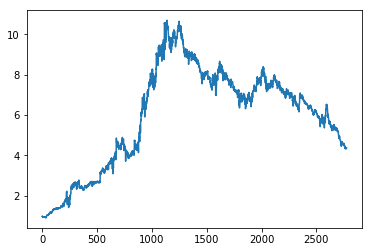

In [66]:
plt.plot(test4)
plt.show()

In [47]:
test2 = execute_backtest('pamr', config)

In [54]:
np.random.uniform(-0.1,0.1)

0.22535903025288206

In [48]:
test4 = execute_backtest('up', config)

In [63]:
test5 = [test5[i]+np.random.uniform(-0.001,0.001) for i in range(len(test5))]

In [24]:
test4

array([ 0.99929518,  1.01211083,  0.9977594 , ...,  0.99451578,
        1.00072253,  1.00193679], dtype=float32)

In [26]:
test5

array([ 0.99935144,  1.01207924,  0.99779475, ...,  0.99468148,
        1.00062442,  1.00190794], dtype=float32)

In [ ]:
test5 = execute_backtest('corn', config)